In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [3]:
path = untar_data(URLs.MNIST)

In [5]:
path.ls()

(#2) [Path('/storage/data/mnist_png/testing'),Path('/storage/data/mnist_png/training')]

In [6]:
(path/'testing').ls()

(#10) [Path('/storage/data/mnist_png/testing/7'),Path('/storage/data/mnist_png/testing/3'),Path('/storage/data/mnist_png/testing/4'),Path('/storage/data/mnist_png/testing/0'),Path('/storage/data/mnist_png/testing/1'),Path('/storage/data/mnist_png/testing/5'),Path('/storage/data/mnist_png/testing/9'),Path('/storage/data/mnist_png/testing/2'),Path('/storage/data/mnist_png/testing/6'),Path('/storage/data/mnist_png/testing/8')]

In [7]:
path

Path('/storage/data/mnist_png')

In [8]:
num = []

In [9]:
num.append((path/'training/0').ls().sorted())

In [10]:
num.append((path/'training/1').ls().sorted())

In [11]:
for i in range(2,10):
    num.append((path/'training'/str(i)).ls().sorted())

In [12]:
num[7]

(#6265) [Path('/storage/data/mnist_png/training/7/10002.png'),Path('/storage/data/mnist_png/training/7/1001.png'),Path('/storage/data/mnist_png/training/7/10014.png'),Path('/storage/data/mnist_png/training/7/10019.png'),Path('/storage/data/mnist_png/training/7/10039.png'),Path('/storage/data/mnist_png/training/7/10046.png'),Path('/storage/data/mnist_png/training/7/10050.png'),Path('/storage/data/mnist_png/training/7/10063.png'),Path('/storage/data/mnist_png/training/7/10077.png'),Path('/storage/data/mnist_png/training/7/10086.png')...]

In [13]:
im_path = num[7][1]
im = Image.open(im_path)
im

In [14]:
num_tensors = []

In [15]:
len(num[1]), len(num[9])

(6742, 5949)

In [16]:
for i in range(10):
    num_tensors.append([tensor(Image.open(o)) for o in num[i]])

In [17]:
len(num_tensors[1]) , len(num_tensors[9])

(6742, 5949)

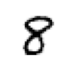

In [18]:
show_image(num_tensors[8][100]);

In [19]:
num_tensors[1][1].shape

torch.Size([28, 28])

In [20]:
num_stacked = []
for i in range(10):
    num_stacked.append(torch.stack(num_tensors[i]).float()/255)

In [21]:
num_stacked[1].shape

torch.Size([6742, 28, 28])

In [22]:
num_stacked[1].ndim

3

# Arrange validate tensors

In [23]:
type(num_stacked[0])

torch.Tensor

In [24]:
len(num_stacked[1])

6742

# sklearn으로 data 분리 test
```하지만 이번 practice에선 train, val분리하지 않는다. dataset의 training을 train data, testing을 test data로 쓴다.```

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
train_idx, val_idx = train_test_split(list(range(1000)), test_size=0.3)

In [27]:
train_idx[:10]

[541, 440, 482, 422, 778, 949, 334, 576, 934, 567]

# concatnate 0~9 data stacks

In [28]:
train_x = torch.cat(num_stacked).view(-1,28*28)

In [29]:
train_x.shape

torch.Size([60000, 784])

In [30]:
train_y = tensor([0]*len(num_tensors[0]) + 
                [1]*len(num_tensors[1]) + 
                [2]*len(num_tensors[2]) + 
                [3]*len(num_tensors[3]) + 
                [4]*len(num_tensors[4]) + 
                [5]*len(num_tensors[5]) + 
                [6]*len(num_tensors[6]) + 
                [7]*len(num_tensors[7]) + 
                [8]*len(num_tensors[8]) + 
                [9]*len(num_tensors[9])).unsqueeze(1)

In [31]:
train_x.shape, train_y.shape

(torch.Size([60000, 784]), torch.Size([60000, 1]))

# preprocess validate data

In [32]:
val = []
for i in range(10):
    val.append((path/'testing'/str(i)).ls().sorted())

In [33]:
val_tensors = []
for i in range(10):
    val_tensors.append([tensor(Image.open(o)) for o in val[i]])

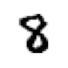

In [34]:
show_image(val_tensors[8][100]);

In [35]:
val_stacked = []
for i in range(10):
    val_stacked.append(torch.stack(val_tensors[i]).float()/255)

In [36]:
val_x = torch.cat(val_stacked).view(-1,28*28)

In [37]:
val_y = tensor([0]*len(val_tensors[0]) + 
                [1]*len(val_tensors[1]) + 
                [2]*len(val_tensors[2]) + 
                [3]*len(val_tensors[3]) + 
                [4]*len(val_tensors[4]) + 
                [5]*len(val_tensors[5]) + 
                [6]*len(val_tensors[6]) + 
                [7]*len(val_tensors[7]) + 
                [8]*len(val_tensors[8]) + 
                [9]*len(val_tensors[9])).unsqueeze(1)

In [38]:
dset = list(zip(train_x, train_y))

In [39]:
x,y = dset[0]
x.shape, y.shape

(torch.Size([784]), torch.Size([1]))

In [40]:
val_dset = list(zip(val_x, val_y))
x,y = val_dset[0]
x.shape, y.shape

(torch.Size([784]), torch.Size([1]))

In [41]:
dl = DataLoader(dset, batch_size=256, shuffle = True)
val_dl = DataLoader(val_dset, batch_size=256, shuffle = True)

# parameter setting

In [42]:
def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()    

In [43]:
w1 = init_params((28*28,10*10))
b1 = init_params(10*10)
w2 = init_params((10*10,10))
b2 = init_params(10)

# prediction

In [44]:
def simple_net(xb):
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [45]:
simple_net(x)

tensor([ 102.2740,  -75.0782,   -8.2698, -142.3971,  -78.9182,   18.9256,   50.4329,   52.2478,   46.6093,   49.5397], grad_fn=<AddBackward0>)

# loss function

In [50]:
torch.softmax(simple_net(x),dim=0)

tensor([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.3428e-37, 3.0600e-23, 1.8790e-22, 6.6855e-25, 1.2526e-23], grad_fn=<SoftmaxBackward0>)

In [51]:
def mnist_loss(predictions, targets):
    predictions = torch.softmax(predictions,dim=0)
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [52]:
def cal_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

# training per epoch

In [53]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        cal_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()
            

# accuracy

In [54]:
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [55]:
torch.softmax(simple_net(xb)[7],dim=0).argmax()

tensor(9)

In [56]:
def batch_acc(preds, yb):
    correct = []
    preds = torch.softmax(preds,dim=0)
    for apreds, ayb in zip(preds, yb):
        correct.append((apreds.argmax() == ayb).float())
    return torch.mean(tensor(correct))

# training

In [57]:
def validate_epoch(model):
    accs = [batch_acc(model(xb), yb) for xb, yb in val_dl]
    return round(torch.stack(accs).mean().item(),4)

In [58]:
validate_epoch(simple_net)

0.1484

In [59]:
lr = 0.1
params = w1,b1,w2,b2

In [60]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model, lr, params)
        print(validate_epoch(model), end=' ')

In [61]:
train_model(simple_net, 20)

0.1469 0.1498 0.148 0.1505 0.1491 0.1437 0.1435 0.152 0.1444 0.1463 0.1483 0.1479 0.144 0.1502 0.1476 0.1576 0.1462 0.1464 0.1529 0.1476 

# simple_net2

In [62]:
simple_net2 = nn.Sequential(
    nn.Linear(28*28,10*10),
    nn.ReLU(),
    nn.Linear(10*10,10*10),
    nn.ReLU(),
    nn.Linear(10*10,10)
)

In [63]:
dls = DataLoaders(dl, val_dl)

In [64]:
learn = Learner(dls, simple_net2, opt_func=SGD,
               loss_func=mnist_loss, metrics=batch_acc)

In [65]:
learn.fit(100,1.0)

epoch,train_loss,valid_loss,batch_acc,time
0,0.117477,0.116593,0.109200,00:00
1,0.114641,0.116561,0.123400,00:01
2,0.113586,0.116588,0.133500,00:00
3,0.113632,0.116539,0.134100,00:00
4,0.116922,0.116533,0.128400,00:00
5,0.117203,0.116519,0.113600,00:00
6,0.115291,0.116479,0.097900,00:00
7,0.116532,0.116409,0.088800,00:00
8,0.117627,0.116254,0.083500,00:00
9,0.114137,0.115874,0.081400,00:01


KeyboardInterrupt: 

# retry
## dataload

In [4]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [5]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [6]:
path = untar_data(URLs.MNIST)

In [7]:
path.ls()

(#2) [Path('/storage/data/mnist_png/testing'),Path('/storage/data/mnist_png/training')]

In [8]:
(path/"testing").ls()

(#10) [Path('/storage/data/mnist_png/testing/7'),Path('/storage/data/mnist_png/testing/3'),Path('/storage/data/mnist_png/testing/4'),Path('/storage/data/mnist_png/testing/0'),Path('/storage/data/mnist_png/testing/1'),Path('/storage/data/mnist_png/testing/5'),Path('/storage/data/mnist_png/testing/9'),Path('/storage/data/mnist_png/testing/2'),Path('/storage/data/mnist_png/testing/6'),Path('/storage/data/mnist_png/testing/8')]

In [9]:
path_tiny = untar_data(URLs.MNIST_TINY)
(path_tiny/"train").ls()

(#2) [Path('/storage/data/mnist_tiny/train/7'),Path('/storage/data/mnist_tiny/train/3')]

## Folder를 기반으로하는 dataloader를 만들고자함.
참고: https://docs.fast.ai/tutorial.datablock.html

https://jonathan-sands.com/deep%20learning/fastai/pytorch/vision/classifier/2020/11/15/MNIST.html

In [10]:
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.3,seed=42),
                 get_y=parent_label)

In [11]:
dls = mnist.dataloaders(path)

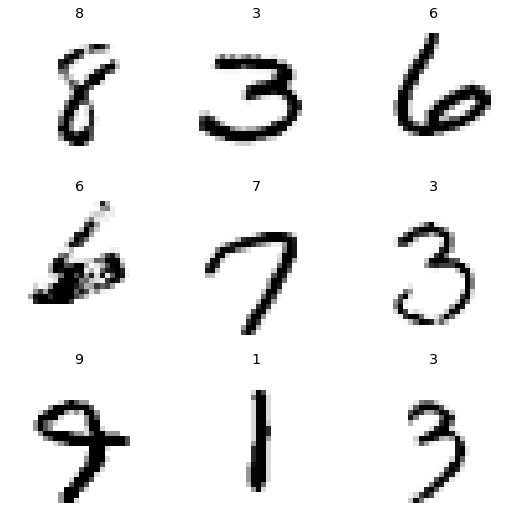

In [12]:
dls.show_batch()

## cnn_learner로 학습함. lr, loss_function등 모두 default로 되어있는 학습

In [13]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.705541,0.461295,0.149143,00:42


epoch,train_loss,valid_loss,error_rate,time
0,0.119642,0.084750,0.030333,00:47
1,0.047336,0.038098,0.012000,00:48


In [14]:
x, y = dls.one_batch()

In [15]:
x,y

(TensorImageBW([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
      

In [16]:
x[0], y[0]

(TensorImageBW([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -

In [17]:
pred, lb = learn.get_preds(dl=[(x,y)])

In [18]:
pred[0], lb[0]

(TensorBase([2.6145e-05, 3.2467e-04, 1.1402e-02, 9.8236e-01, 7.7331e-05, 1.9726e-03, 8.6780e-05, 5.3023e-04, 2.3102e-03, 9.0986e-04]),
 TensorCategory(3))

In [19]:
pred[0].sum()

TensorBase(1.)

In [20]:
sm_acts = torch.softmax(pred[:6], dim=0)

In [21]:
sm_acts

TensorBase([[0.1667, 0.1667, 0.1316, 0.2845, 0.1296, 0.1669, 0.1296, 0.1296, 0.1666, 0.1668],
        [0.1667, 0.1667, 0.1301, 0.1065, 0.3522, 0.1666, 0.1296, 0.1296, 0.1662, 0.1666],
        [0.1667, 0.1667, 0.1301, 0.1065, 0.1296, 0.1666, 0.1296, 0.3521, 0.1662, 0.1666],
        [0.1667, 0.1667, 0.3480, 0.1066, 0.1296, 0.1667, 0.1296, 0.1296, 0.1685, 0.1666],
        [0.1667, 0.1667, 0.1301, 0.1065, 0.1296, 0.1666, 0.3520, 0.1296, 0.1662, 0.1666],
        [0.1667, 0.1667, 0.1301, 0.2893, 0.1296, 0.1666, 0.1296, 0.1296, 0.1664, 0.1666]])

In [22]:
sm_acts[range(6),lb[:6]]

TensorCategory([0.2845, 0.3522, 0.3521, 0.3480, 0.3520, 0.2893])

In [24]:
F.nll_loss(sm_acts, lb[:6], reduction='none')

TensorCategory([-0.2845, -0.3522, -0.3521, -0.3480, -0.3520, -0.2893])

In [41]:
lsm_acts = torch.log_softmax(pred[:6], dim=1)

In [42]:
lsm_acts[range(6),lb[:6]]

TensorCategory([-1.4762, -1.4612, -1.4612, -1.4750, -1.4618, -1.4622])

In [43]:
F.nll_loss(lsm_acts, lb[:6], reduction='none')

TensorCategory([1.4762, 1.4612, 1.4612, 1.4750, 1.4618, 1.4622])

## CrossEntropyLoss == log_softmax & nll_loss

In [23]:
loss_func = nn.CrossEntropyLoss()

In [25]:
loss_func(pred[:6], lb[:6])

TensorCategory(1.4663)

In [31]:
nn.CrossEntropyLoss(reduction='none')(pred[:6], lb[:6])

TensorCategory([1.4762, 1.4612, 1.4612, 1.4750, 1.4618, 1.4622])

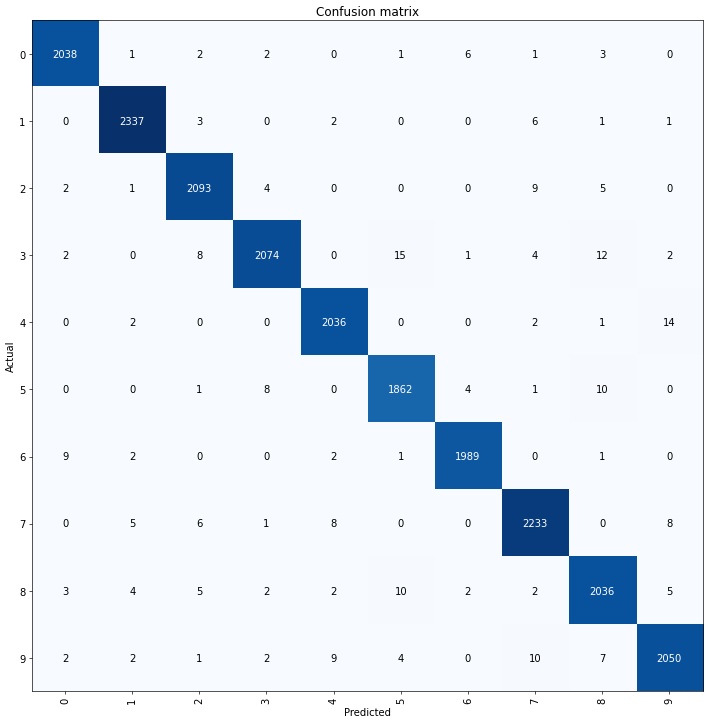

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [49]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.200880,0.117427,0.035429,00:41
1,0.073964,0.047149,0.014333,00:42
2,0.058717,0.033690,0.010190,00:41


In [50]:
learn.unfreeze()

SuggestedLRs(valley=1.737800812406931e-05)

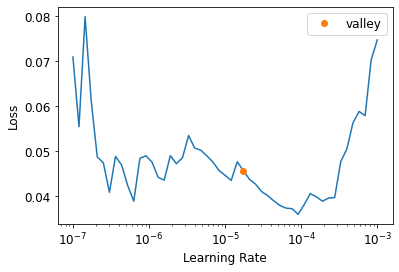

In [52]:
learn.lr_find()

In [53]:
learn.fit_one_cycle(6, lr_max=1.737800812406931e-05)

epoch,train_loss,valid_loss,error_rate,time
0,0.044929,0.032491,0.010000,00:51
1,0.030256,0.029344,0.008810,00:47
2,0.018949,0.027328,0.008476,00:47
3,0.014557,0.024642,0.007238,00:47
4,0.010065,0.023252,0.006905,00:47
5,0.007541,0.023508,0.007048,00:47


In [54]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(6, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.196394,0.115994,0.036048,00:39
1,0.072621,0.048167,0.014857,00:40
2,0.055260,0.037499,0.011857,00:40


epoch,train_loss,valid_loss,error_rate,time
0,0.047631,0.033828,0.010524,00:47
1,0.042454,0.031318,0.009952,00:48
2,0.029722,0.030402,0.009429,00:51
3,0.020916,0.028777,0.008857,00:47
4,0.019055,0.028733,0.008571,00:48
5,0.012546,0.029932,0.008810,00:48


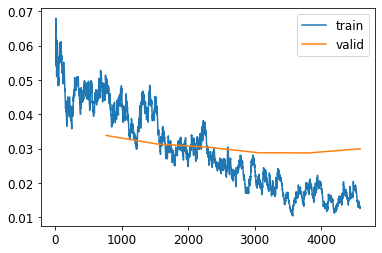

In [55]:
learn.recorder.plot_loss()

In [61]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet34, metrics=error_rate).to_fp16()
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(6, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.282935,0.131010,0.038952,00:43
1,0.125746,0.058912,0.016238,00:46
2,0.092344,0.043261,0.013143,00:43


epoch,train_loss,valid_loss,error_rate,time
0,0.090354,0.042899,0.012429,00:51
1,0.083743,0.046074,0.013190,00:50
2,0.075483,0.042850,0.012714,00:51
3,0.082804,0.042498,0.012143,00:50
4,0.071414,0.042782,0.012762,00:51
5,0.087534,0.042762,0.012667,00:51


In [59]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(9, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,3.309914,2.544050,0.829381,00:59
1,2.130124,1.591764,0.504809,01:00
2,0.928471,0.628012,0.174857,00:59


epoch,train_loss,valid_loss,error_rate,time
0,0.784946,0.542180,0.152238,01:09
1,0.599869,0.402625,0.115619,01:11
2,0.458596,0.298423,0.089476,01:10
3,0.368974,0.233379,0.069048,01:10
4,0.333207,0.197942,0.059810,01:10
5,0.286530,0.178663,0.054333,01:12


KeyboardInterrupt: 

In [60]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(9, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,3.281467,2.561641,0.838667,00:57


KeyboardInterrupt: 